In [8]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import pickle
import logging
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb


In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Initialize the logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [5]:
def load_data(path):
    try:
        df = pd.read_csv(path, low_memory=False)
        return df
    except Exception as e:
        logger.info(f"Error on Loding Data {e}")

In [6]:
path = "../data/02_intermediate/train_clean.csv"
df = load_data(path)

In [6]:
df.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Week,Month,Year,Season
0,0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,...,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
1,1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
2,2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
3,3,4,5,2015-07-31,13995.0,NaN,1,1,0,1,...,2009.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
4,4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,...,2015.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer


In [7]:
logger.info("Droping unecessary coulmuns")
df = df.drop(['Unnamed: 0', 'Date'], axis=1)

2024-06-04 09:48:29,549 - INFO - Droping unecessary coulmuns


In [9]:
# Preprocessing pipeline
def create_preprocessing_pipeline(numeric_features, categorical_features):
    logger.info("Creating preprocessing pipeline")
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor

In [10]:
# Train and evaluate the model
def train_evaluate_model(df, target_column):
    logger.info("Starting model training and evaluation")
    
    # Define features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Define numeric and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)
    
    # Preprocess the features
    logger.info("Preprocessing the features")
    X_preprocessed = preprocessor.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
    
    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test, y_test)
    
    # Define hyperparameters
    params = {"objective": "reg:squarederror", "tree_method": "hist"}
    n = 5000

    evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
    
     # Train XGBoost model
    logger.info("Training XGBoost model")
    model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,
    early_stopping_rounds=50)
    
    # Make predictions
    logger.info("Making predictions")
    y_pred = model.predict(dtest_reg)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    logger.info(f'Root_Mean Squared Error: {rmse}')
    
    return model, y_pred, y_test, X

In [11]:
df['Sales'] = df['Sales'].fillna(df['Sales'].mean())
model, y_pred, y_test, X = train_evaluate_model(df, 'Sales')


2024-06-04 09:48:56,938 - INFO - Starting model training and evaluation
2024-06-04 09:48:57,186 - INFO - Creating preprocessing pipeline
2024-06-04 09:48:57,187 - INFO - Preprocessing the features
2024-06-04 09:49:07,294 - INFO - Training XGBoost model


[0]	validation-rmse:2494.50778	train-rmse:2499.53086
[50]	validation-rmse:929.94465	train-rmse:915.15722
[100]	validation-rmse:833.30605	train-rmse:807.80267
[150]	validation-rmse:793.97869	train-rmse:760.71521
[200]	validation-rmse:766.97616	train-rmse:727.29312
[250]	validation-rmse:750.06752	train-rmse:703.29122
[300]	validation-rmse:738.17181	train-rmse:685.40278
[350]	validation-rmse:728.88847	train-rmse:670.34929
[400]	validation-rmse:722.43843	train-rmse:657.53790
[450]	validation-rmse:716.94577	train-rmse:645.46578
[500]	validation-rmse:713.40937	train-rmse:635.68212
[550]	validation-rmse:709.54597	train-rmse:626.83085
[600]	validation-rmse:706.47364	train-rmse:618.34924
[650]	validation-rmse:704.45307	train-rmse:611.19087
[700]	validation-rmse:702.65559	train-rmse:604.62682
[750]	validation-rmse:700.65600	train-rmse:597.87002
[800]	validation-rmse:698.53502	train-rmse:591.79062
[850]	validation-rmse:696.85497	train-rmse:585.54212
[900]	validation-rmse:695.66258	train-rmse:580.

2024-06-04 09:57:45,714 - INFO - Making predictions
2024-06-04 09:57:56,375 - INFO - Root_Mean Squared Error: 689.7315122022644


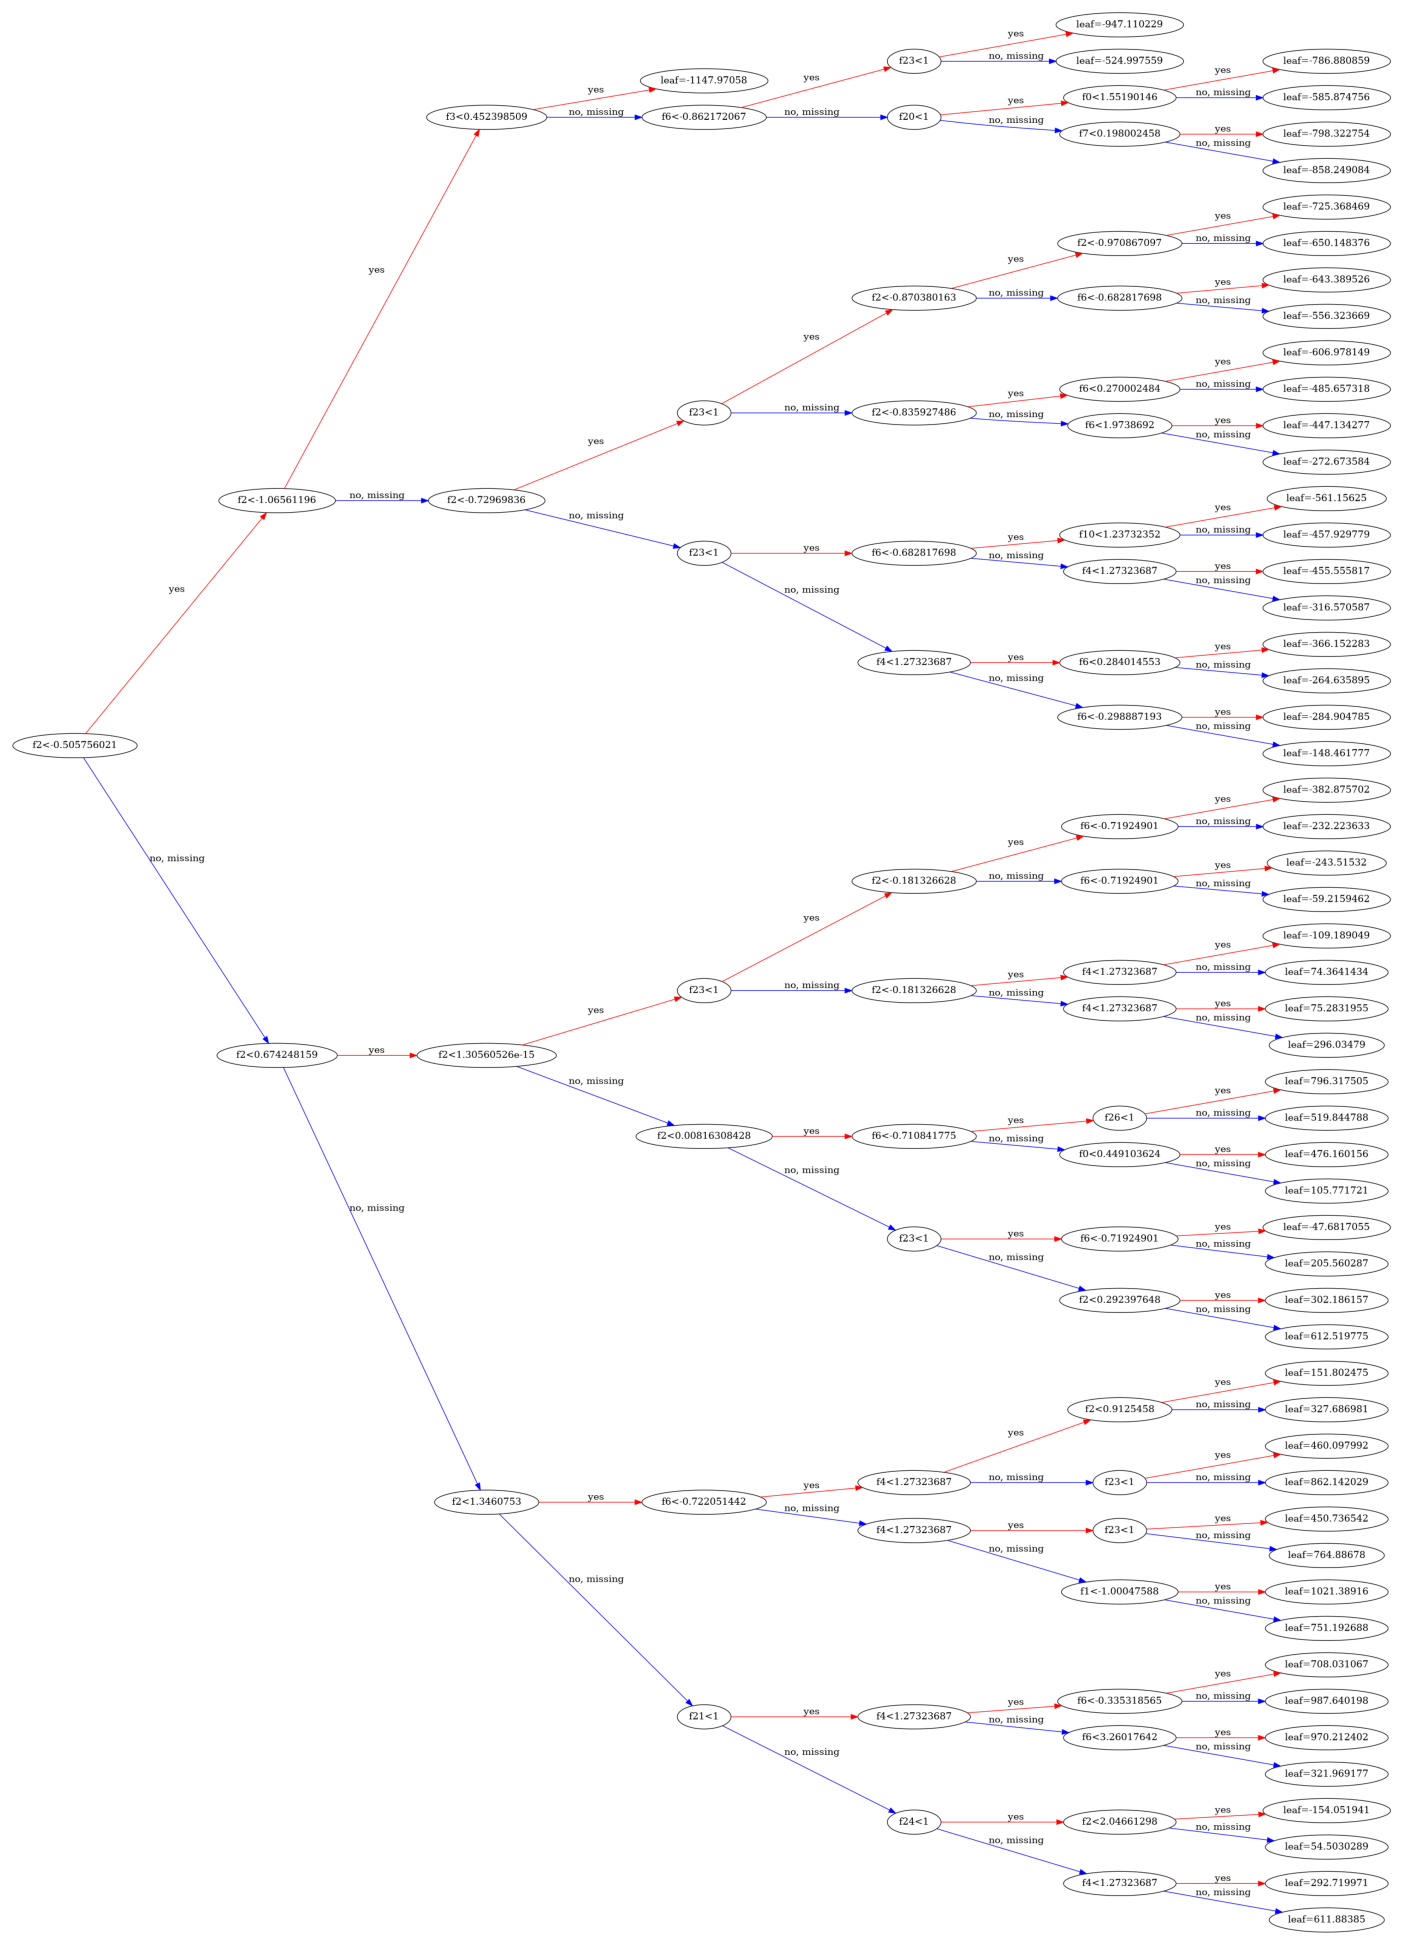

In [11]:
rcParams['figure.figsize'] = 35,25
xgb.plot_tree(model, rankdir= 'LR', num_trees=1);

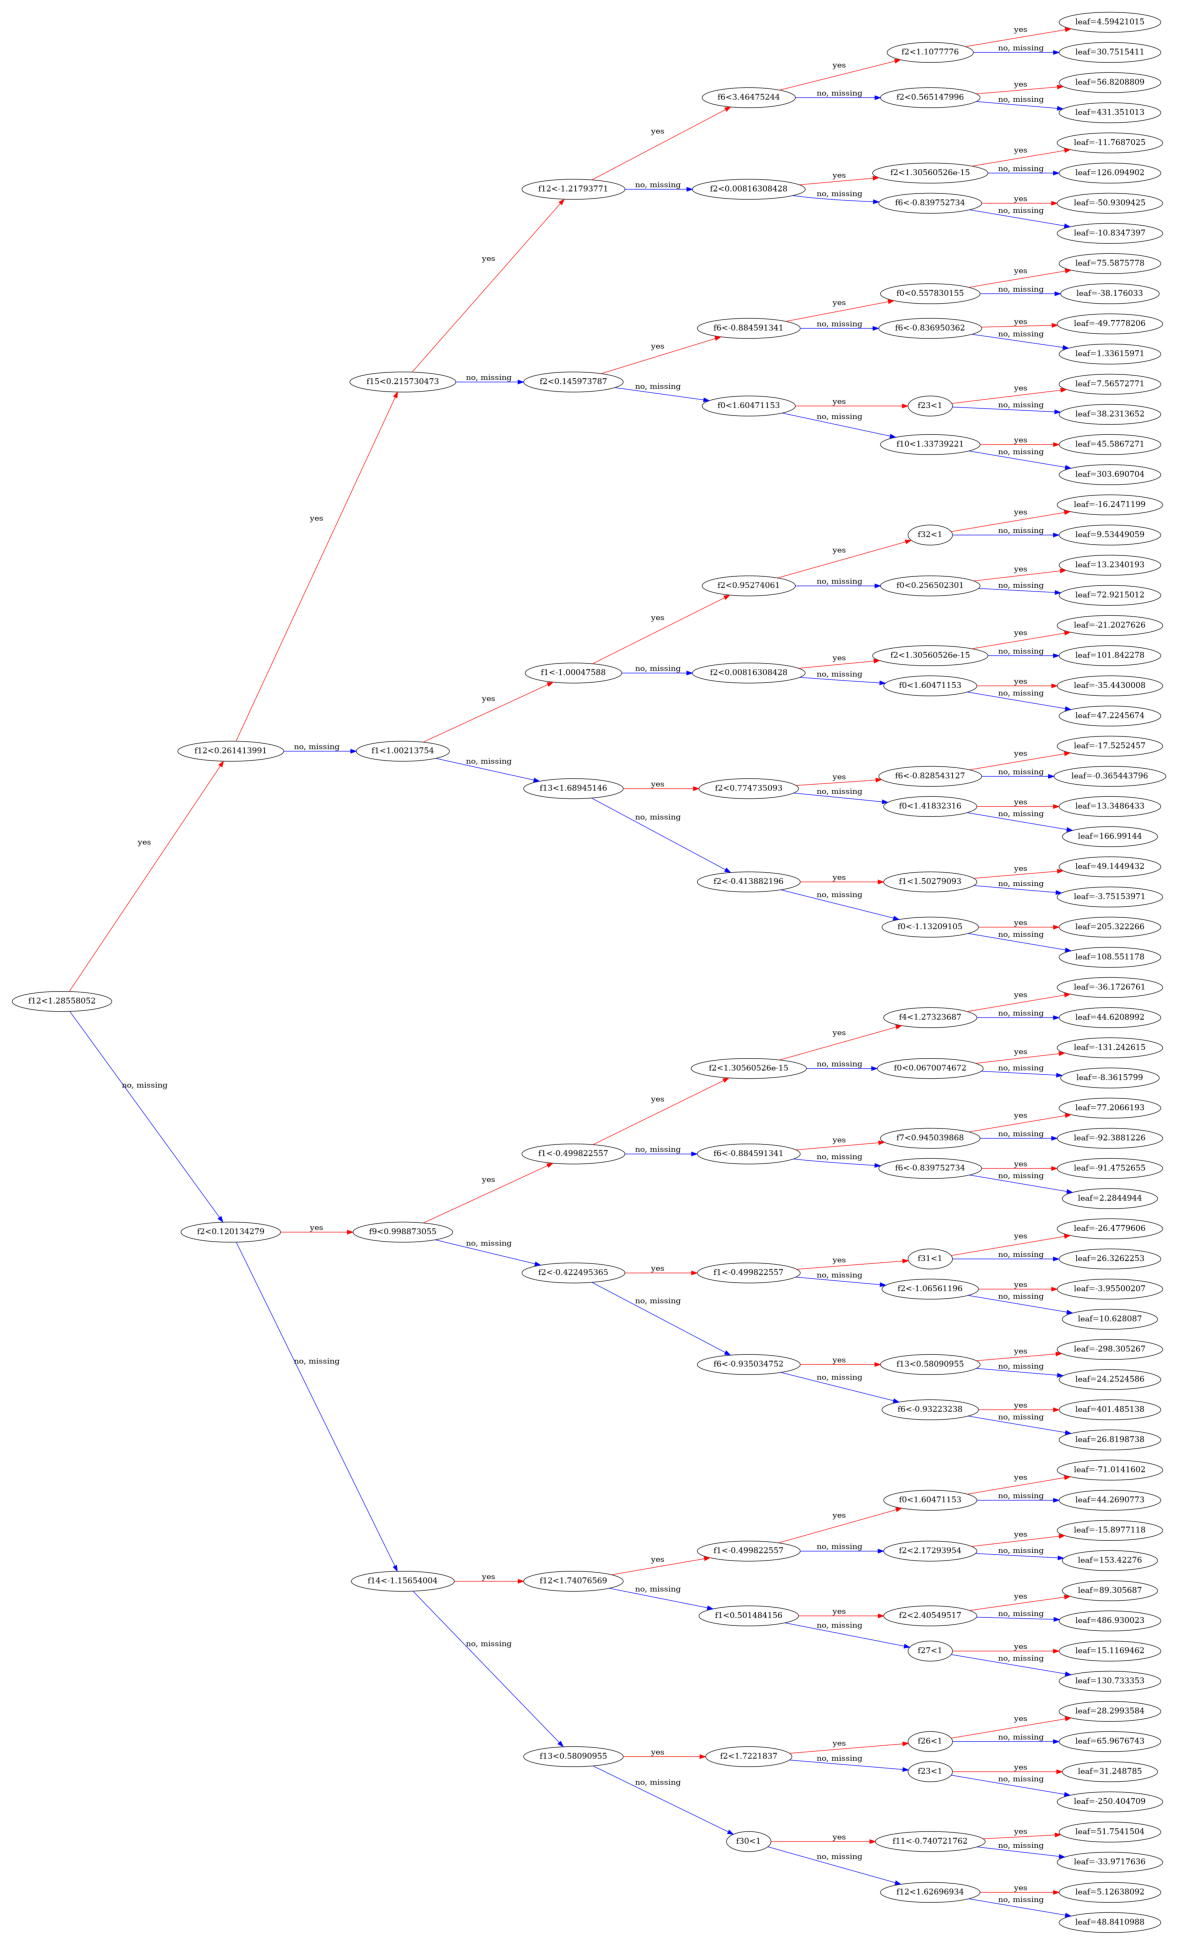

In [12]:
xgb.plot_tree(model, rankdir= 'LR',  num_trees=20);

In [13]:
#  Interpret Feature Importances
feature_importance = model.get_score(importance_type='gain')
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance[:10]:
    print(f'{feature}: {importance}')


f2: 225777712.0
f23: 156545232.0
f25: 57416444.0
f4: 51090652.0
f21: 38668872.0
f3: 32618438.0
f9: 28449310.0
f26: 24281298.0
f24: 16839578.0
f6: 14220561.0


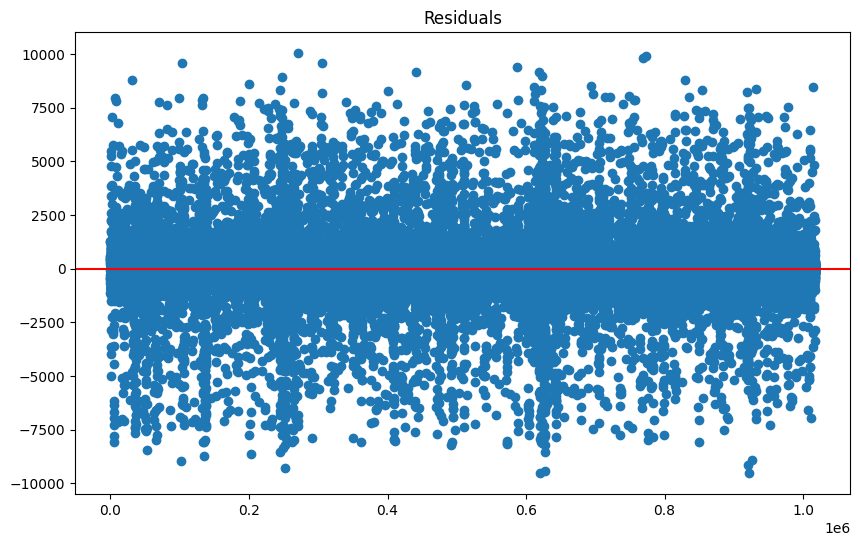

In [13]:
# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals')
plt.show()

# Serialize The Model

In [12]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
filename = f'xgbmodel_{timestamp}.pkl'
pickle.dump(model, open(filename, 'wb'))